In [25]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as ncdf
import pandas as pd
import os
%matplotlib inline

In [2]:
from moa_python.post_abl_stats import Post_abl_stats
from moa_python.post_plane import Post_plane

In [3]:
case_folder = ['/Users/ahenry/Documents/toolboxes/wind-hybrid-open-controller/examples']#,'/lustre/eaglefs/projects/ssc/jfrederi/amr-wind-runs/precursor-new/baseline_8ms_dt002_dx2p5']#,'/projects/ssc/jfrederi/precursors-amr-wind/neutral_highti_8ms/precursor','/projects/ssc/jfrederi/precursors-amr-wind/neutral_highti_rthedin']#,'/projects/ssc/jfrederi/precursors-amr-wind/neutral_lowti_8ms/precursor','/projects/ssc/jfrederi/precursors-amr-wind/neutral_lowti_9ms/precursor','/projects/ssc/jfrederi/precursors-amr-wind/neutral_lowti_10ms/precursor','/projects/ssc/jfrederi/precursors-amr-wind/neutral_lowti_12ms','/projects/ssc/jfrederi/precursors-amr-wind/neutral_lowti_12ms']
# case_folder = ['/projects/ssc/jfrederi/amr-wind-runs/precursor-new/baseline_grid1.25_eps3.125']

abl_stats_file = ['post_processing/abl_statistics00000.nc']#,'post_processing/abl_statistics14400.nc','abl_statistics129531.nc']
hor_plane_file = ['post_processing/samplingPlane00000.nc']

abl = []
plane = []
if isinstance(case_folder,list):
    full_filename_abl_stats = []
    full_filename_hor_plane = []
    for n in range(len(case_folder)):
        full_filename_abl_stats = os.path.join(case_folder[n],abl_stats_file[n])
        full_filename_plane = os.path.join(case_folder[n],hor_plane_file[n])
        abl.append(Post_abl_stats(full_filename_abl_stats))
        #plane.append(Post_plane(full_filename_plane))
else:
    abl = Post_abl_stats(os.path.join(case_folder, abl_stats_file))
    #plane = Post_plane(os.path.join(case_folder,hor_plane_file))

Ncases = len(case_folder)

Object is composed of 1 and time runs from 0.5 to 10800.0
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: AMR-Wind ABL statistics output
    version: 754dd54e0dd4
    created_on: Tue Apr 30 09:58:28 2024

    dimensions(sizes): num_time_steps(21600), ndim(3)
    variables(dimensions): float64 time(num_time_steps), float64 Q(num_time_steps), float64 Tsurf(num_time_steps), float64 ustar(num_time_steps), float64 wstar(num_time_steps), float64 L(num_time_steps), float64 zi(num_time_steps), float64 abl_forcing_x(num_time_steps), float64 abl_forcing_y(num_time_steps)
    groups: mean_profiles


In [4]:
u = abl[0].get_data_from_mean_profiles('u')
u_avg = abl[0].time_average_data(u, 7200, 10800)
v = abl[0].get_data_from_mean_profiles('v')
v_avg = abl[0].time_average_data(v, 7200, 10800)

print(abl[0].z.shape)
print(u.shape, u_avg.shape) # (Time, n_cells at coursest level in vertical z plane, 1)
print(v.shape, v_avg.shape) # (Time, n_cells at coursest level in vertical z plane, 1)



(128, 1)
(21600, 128, 1) (128, 1)
(21600, 128, 1) (128, 1)


In [18]:
#print(plane[0].vel_planes['x'].shape) # (n_time_steps in plane, 512*512*4plane_offsets)
#print(np.arange(0,dataset.dimensions['num_time_steps'].size,1))
#print(plane[0].dataset.groups[plane[0].plane].variables['velocityx'].shape)

(2161, 1048576)
(2161, 1048576)


In [37]:
settling_time = 7200
height = 90

# print(abl[0].time[abl[0].time>=settling_time])
settled_time_idx = abl[0].time >= settling_time
settled_time = abl[0].time[settled_time_idx]
settled_u = abl[0].get_time_series_at_height('u', height)[settled_time_idx]
settled_v = abl[0].get_time_series_at_height('v', height)[settled_time_idx]

u_preview_samples = []
v_preview_samples = []

n_horizon = 10
controller_dt = 60
simulation_dt = 0.5
n_preview_steps = int(n_horizon * controller_dt // simulation_dt)
preview_dt = int(controller_dt // simulation_dt)
time_series_dt = 1
for k in range(int(len(settled_time) - (n_preview_steps + preview_dt))):
    # print(k, len(settled_u[k:k+n_preview_steps + preview_dt:time_series_dt]))
    u_preview_samples.append(settled_u[k:k+n_preview_steps + preview_dt:time_series_dt])
    v_preview_samples.append(settled_v[k:k+n_preview_steps + preview_dt:time_series_dt])

u_preview_samples = np.vstack(u_preview_samples)
v_preview_samples = np.vstack(v_preview_samples)

mean_u = np.mean(settled_u)
cov_u = np.cov(u_preview_samples, rowvar=False)
mean_v = np.mean(settled_v)
cov_v = np.cov(v_preview_samples, rowvar=False)

print(mean_u.shape)
print(cov_u.shape) 
# abl[2].time = abl[2].time - 25000+settling_time

Nearest height to 90 is [85.]
Nearest height to 90 is [85.]
()
(1320, 1320)


1320
120
[ 7200.   7200.5  7201.  ... 10799.  10799.5 10800. ] (7201,)


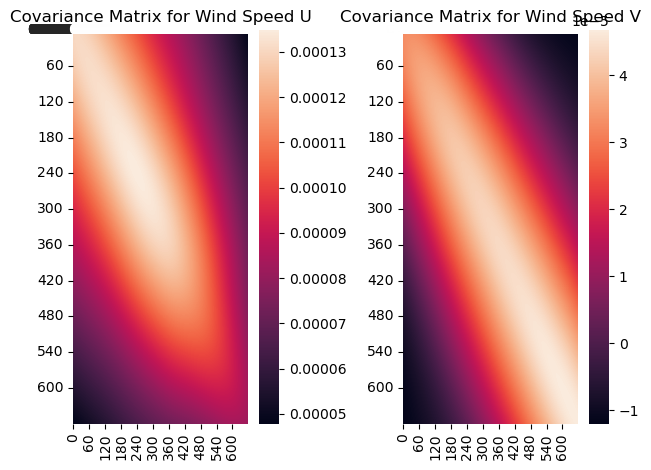

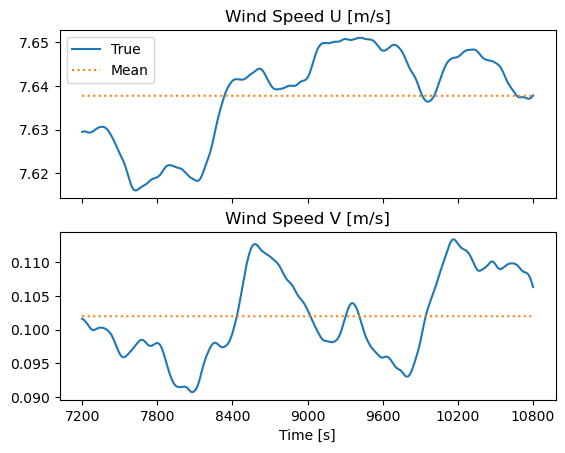

In [55]:
print(int(n_preview_steps + preview_dt))
print(preview_dt)
print(settled_time, settled_time.shape)

fig, ax = plt.subplots(1, 2) 
sns.heatmap(cov_u, annot=True, fmt='g', ax=ax[0], annot_kws={'size': 10})
sns.heatmap(cov_v, annot=True, fmt='g', ax=ax[1], annot_kws={'size': 10})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax[0].set_title('Covariance Matrix for Wind Speed U') 
ax[1].set_title('Covariance Matrix for Wind Speed V') 
ax[0].set_xticks(np.arange(0, int(n_preview_steps + preview_dt), preview_dt))
ax[1].set_xticks(np.arange(0, int(n_preview_steps + preview_dt), preview_dt))
ax[0].set_yticks(np.arange(0, int(n_preview_steps + preview_dt), preview_dt))
ax[1].set_yticks(np.arange(0, int(n_preview_steps + preview_dt), preview_dt))
ax[0].set_xticklabels((ax[0].get_xticks() * simulation_dt).astype(int))
ax[1].set_xticklabels((ax[1].get_xticks() * simulation_dt).astype(int))
ax[0].set_yticklabels((ax[0].get_yticks() * simulation_dt).astype(int))
ax[1].set_yticklabels((ax[1].get_yticks() * simulation_dt).astype(int))
fig.tight_layout()
# ax.xaxis.set_ticklabels(class_names,rotation=90, fontsize = 10)
# ax.yaxis.set_ticklabels(class_names,rotation=0, fontsize = 10)

fig, axarr = plt.subplots(2, 1, sharex=True)
axarr[0].plot(settled_time, settled_u, label="True")
axarr[0].plot(settled_time, [mean_u] * len(settled_time), linestyle=":", label="Mean")
axarr[0].set(title="Wind Speed U [m/s]")
axarr[0].legend()
axarr[1].plot(settled_time, settled_v, label="v")
axarr[1].plot(settled_time, [mean_v] * len(settled_time), linestyle=":", label="mean_v")
axarr[1].set(title="Wind Speed V [m/s]", xlabel="Time [s]")
axarr[1].set_xticks(settled_time[::n_preview_steps])
#axarr[1].set_xticklabels((axarr[1].get_xticks() * simulation_dt).astype(int))


Nearest height to 90 is [85.]
Nearest height to 90 is [85.]
Nearest height to 90 is [85.]
Nearest height to 90 is [85.]
Nearest height to 90 is [85.]
Nearest height to 90 is [85.]
Nearest height to 90 is [85.]


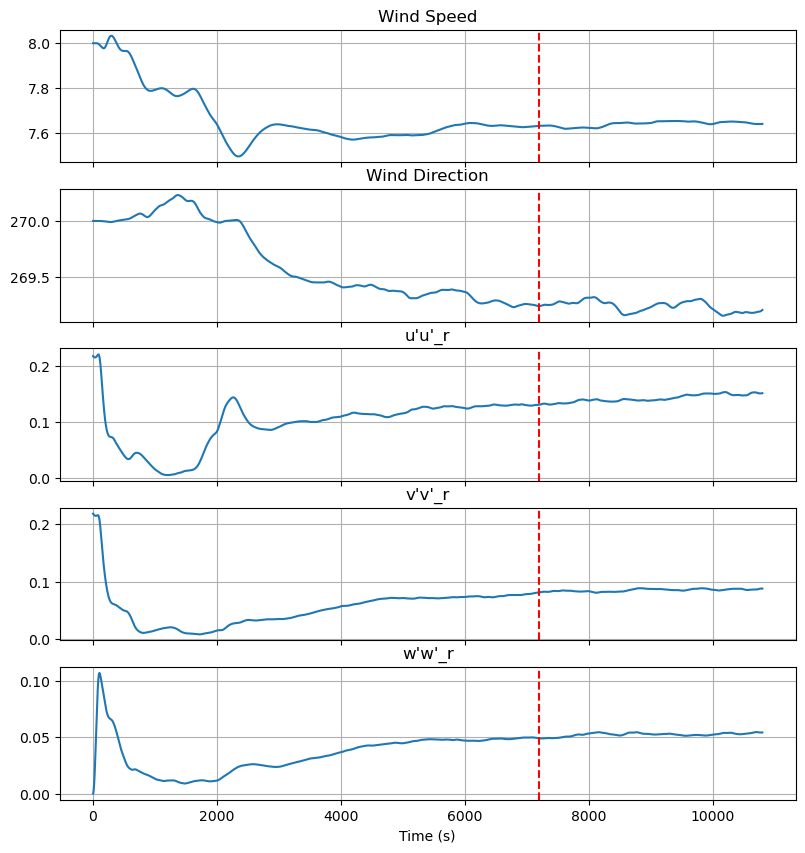

In [56]:
fig, axarr = plt.subplots(5,1,figsize=(9.5,10), sharex=True)

for n in range(Ncases):
    abl[n].plot_wind_measurements_at_height(height, axarr, settling_time = settling_time)

In [25]:
fig, ax = plt.subplots()
for n in range(Ncases):
    abl[n].plot_vertical_temp_profile(t_min=settling_time, ax=ax)


<IPython.core.display.Javascript object>

In [24]:
fig, ax = plt.subplots()
for n in range(Ncases):
    abl[n].plot_vertical_vel_profile(t_min=settling_time, height=height, ax=ax)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


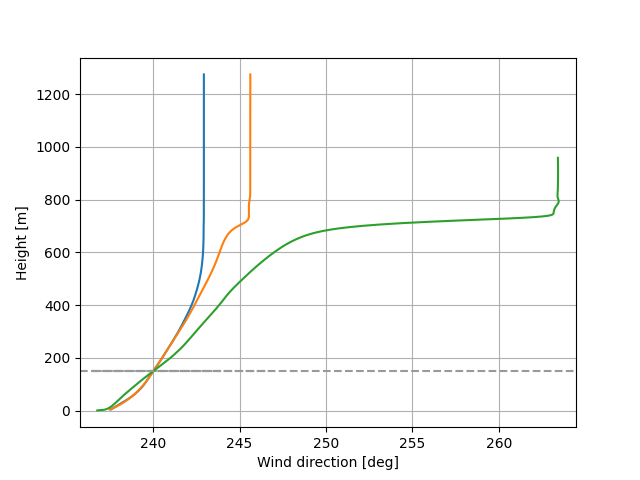

Nearest height to [5.] is [5.]
Nearest height to [5.] is [5.]
Nearest height to [15.] is [15.]
Nearest height to [15.] is [15.]
Nearest height to [25.] is [25.]
Nearest height to [25.] is [25.]
Nearest height to [35.] is [35.]
Nearest height to [35.] is [35.]
Nearest height to [45.] is [45.]
Nearest height to [45.] is [45.]
Nearest height to [55.] is [55.]
Nearest height to [55.] is [55.]
Nearest height to [65.] is [65.]
Nearest height to [65.] is [65.]
Nearest height to [75.] is [75.]
Nearest height to [75.] is [75.]
Nearest height to [85.] is [85.]
Nearest height to [85.] is [85.]
Nearest height to [95.] is [95.]
Nearest height to [95.] is [95.]
Nearest height to [105.] is [105.]
Nearest height to [105.] is [105.]
Nearest height to [115.] is [115.]
Nearest height to [115.] is [115.]
Nearest height to [125.] is [125.]
Nearest height to [125.] is [125.]
Nearest height to [135.] is [135.]
Nearest height to [135.] is [135.]
Nearest height to [145.] is [145.]
Nearest height to [145.] is [

Nearest height to [1175.] is [1175.]
Nearest height to [1175.] is [1175.]
Nearest height to [1185.] is [1185.]
Nearest height to [1185.] is [1185.]
Nearest height to [1195.] is [1195.]
Nearest height to [1195.] is [1195.]
Nearest height to [1205.] is [1205.]
Nearest height to [1205.] is [1205.]
Nearest height to [1215.] is [1215.]
Nearest height to [1215.] is [1215.]
Nearest height to [1225.] is [1225.]
Nearest height to [1225.] is [1225.]
Nearest height to [1235.] is [1235.]
Nearest height to [1235.] is [1235.]
Nearest height to [1245.] is [1245.]
Nearest height to [1245.] is [1245.]
Nearest height to [1255.] is [1255.]
Nearest height to [1255.] is [1255.]
Nearest height to [1265.] is [1265.]
Nearest height to [1265.] is [1265.]
Nearest height to [1275.] is [1275.]
Nearest height to [1275.] is [1275.]
Nearest height to [5.] is [5.]
Nearest height to [5.] is [5.]
Nearest height to [15.] is [15.]
Nearest height to [15.] is [15.]
Nearest height to [25.] is [25.]
Nearest height to [25.] i

Nearest height to [1065.] is [1065.]
Nearest height to [1065.] is [1065.]
Nearest height to [1075.] is [1075.]
Nearest height to [1075.] is [1075.]
Nearest height to [1085.] is [1085.]
Nearest height to [1085.] is [1085.]
Nearest height to [1095.] is [1095.]
Nearest height to [1095.] is [1095.]
Nearest height to [1105.] is [1105.]
Nearest height to [1105.] is [1105.]
Nearest height to [1115.] is [1115.]
Nearest height to [1115.] is [1115.]
Nearest height to [1125.] is [1125.]
Nearest height to [1125.] is [1125.]
Nearest height to [1135.] is [1135.]
Nearest height to [1135.] is [1135.]
Nearest height to [1145.] is [1145.]
Nearest height to [1145.] is [1145.]
Nearest height to [1155.] is [1155.]
Nearest height to [1155.] is [1155.]
Nearest height to [1165.] is [1165.]
Nearest height to [1165.] is [1165.]
Nearest height to [1175.] is [1175.]
Nearest height to [1175.] is [1175.]
Nearest height to [1185.] is [1185.]
Nearest height to [1185.] is [1185.]
Nearest height to [1195.] is [1195.]
N

Nearest height to [306.25] is [306.25]
Nearest height to [308.75] is [308.75]
Nearest height to [308.75] is [308.75]
Nearest height to [311.25] is [311.25]
Nearest height to [311.25] is [311.25]
Nearest height to [313.75] is [313.75]
Nearest height to [313.75] is [313.75]
Nearest height to [316.25] is [316.25]
Nearest height to [316.25] is [316.25]
Nearest height to [318.75] is [318.75]
Nearest height to [318.75] is [318.75]
Nearest height to [321.25] is [321.25]
Nearest height to [321.25] is [321.25]
Nearest height to [323.75] is [323.75]
Nearest height to [323.75] is [323.75]
Nearest height to [326.25] is [326.25]
Nearest height to [326.25] is [326.25]
Nearest height to [328.75] is [328.75]
Nearest height to [328.75] is [328.75]
Nearest height to [331.25] is [331.25]
Nearest height to [331.25] is [331.25]
Nearest height to [333.75] is [333.75]
Nearest height to [333.75] is [333.75]
Nearest height to [336.25] is [336.25]
Nearest height to [336.25] is [336.25]
Nearest height to [338.75

Nearest height to [613.75] is [613.75]
Nearest height to [616.25] is [616.25]
Nearest height to [616.25] is [616.25]
Nearest height to [618.75] is [618.75]
Nearest height to [618.75] is [618.75]
Nearest height to [621.25] is [621.25]
Nearest height to [621.25] is [621.25]
Nearest height to [623.75] is [623.75]
Nearest height to [623.75] is [623.75]
Nearest height to [626.25] is [626.25]
Nearest height to [626.25] is [626.25]
Nearest height to [628.75] is [628.75]
Nearest height to [628.75] is [628.75]
Nearest height to [631.25] is [631.25]
Nearest height to [631.25] is [631.25]
Nearest height to [633.75] is [633.75]
Nearest height to [633.75] is [633.75]
Nearest height to [636.25] is [636.25]
Nearest height to [636.25] is [636.25]
Nearest height to [638.75] is [638.75]
Nearest height to [638.75] is [638.75]
Nearest height to [641.25] is [641.25]
Nearest height to [641.25] is [641.25]
Nearest height to [643.75] is [643.75]
Nearest height to [643.75] is [643.75]
Nearest height to [646.25

Nearest height to [921.25] is [921.25]
Nearest height to [923.75] is [923.75]
Nearest height to [923.75] is [923.75]
Nearest height to [926.25] is [926.25]
Nearest height to [926.25] is [926.25]
Nearest height to [928.75] is [928.75]
Nearest height to [928.75] is [928.75]
Nearest height to [931.25] is [931.25]
Nearest height to [931.25] is [931.25]
Nearest height to [933.75] is [933.75]
Nearest height to [933.75] is [933.75]
Nearest height to [936.25] is [936.25]
Nearest height to [936.25] is [936.25]
Nearest height to [938.75] is [938.75]
Nearest height to [938.75] is [938.75]
Nearest height to [941.25] is [941.25]
Nearest height to [941.25] is [941.25]
Nearest height to [943.75] is [943.75]
Nearest height to [943.75] is [943.75]
Nearest height to [946.25] is [946.25]
Nearest height to [946.25] is [946.25]
Nearest height to [948.75] is [948.75]
Nearest height to [948.75] is [948.75]
Nearest height to [951.25] is [951.25]
Nearest height to [951.25] is [951.25]
Nearest height to [953.75

In [23]:
fig, ax = plt.subplots()
offset = [0, 0, 30]
for n in range(Ncases):
    abl[n].plot_wind_direction_profile(t_min=settling_time, height=height, ax=ax, offset=offset[n])

In [24]:
for n in range(Ncases):
    veer = abl[n].get_wind_veer(height, 240, t_min=settling_time)
    print(f'Veer is {veer} degrees')

Nearest height to [[35.]] is [35.]
Nearest height to [[35.]] is [35.]
Nearest height to [[45.]] is [45.]
Nearest height to [[45.]] is [45.]
Nearest height to [[55.]] is [55.]
Nearest height to [[55.]] is [55.]
Nearest height to [[65.]] is [65.]
Nearest height to [[65.]] is [65.]
Nearest height to [[75.]] is [75.]
Nearest height to [[75.]] is [75.]
Nearest height to [[85.]] is [85.]
Nearest height to [[85.]] is [85.]
Nearest height to [[95.]] is [95.]
Nearest height to [[95.]] is [95.]
Nearest height to [[105.]] is [105.]
Nearest height to [[105.]] is [105.]
Nearest height to [[115.]] is [115.]
Nearest height to [[115.]] is [115.]
Nearest height to [[125.]] is [125.]
Nearest height to [[125.]] is [125.]
Nearest height to [[135.]] is [135.]
Nearest height to [[135.]] is [135.]
Nearest height to [[145.]] is [145.]
Nearest height to [[145.]] is [145.]
Nearest height to [[155.]] is [155.]
Nearest height to [[155.]] is [155.]
Nearest height to [[165.]] is [165.]
Nearest height to [[165.]] is

Nearest height to [[233.75]] is [233.75]
Nearest height to [[236.25]] is [236.25]
Nearest height to [[236.25]] is [236.25]
Nearest height to [[238.75]] is [238.75]
Nearest height to [[238.75]] is [238.75]
Nearest height to [[241.25]] is [241.25]
Nearest height to [[241.25]] is [241.25]
Nearest height to [[243.75]] is [243.75]
Nearest height to [[243.75]] is [243.75]
Nearest height to [[246.25]] is [246.25]
Nearest height to [[246.25]] is [246.25]
Nearest height to [[248.75]] is [248.75]
Nearest height to [[248.75]] is [248.75]
Nearest height to [[251.25]] is [251.25]
Nearest height to [[251.25]] is [251.25]
Nearest height to [[253.75]] is [253.75]
Nearest height to [[253.75]] is [253.75]
Nearest height to [[256.25]] is [256.25]
Nearest height to [[256.25]] is [256.25]
Nearest height to [[258.75]] is [258.75]
Nearest height to [[258.75]] is [258.75]
Nearest height to [[261.25]] is [261.25]
Nearest height to [[261.25]] is [261.25]
Nearest height to [[263.75]] is [263.75]
Nearest height t

In [25]:
for n in range(Ncases):
    TI = abl[n].get_turbulence_intensity_at_height(height, t_min=settling_time)

    print('Turbulence Intensity [%]: ', TI)

Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Turbulence Intensity [%]:  3.438304109229361
Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Nearest height to 150 is [145.]
Turbulence Intensity [%]:  6.989827677760645
Nearest height to 150 is [148.75]
Nearest height to 150 is [148.75]
Nearest height to 150 is [148.75]
Nearest height to 150 is [148.75]
Nearest height to 150 is [148.75]
Nearest height to 150 is [148.75]
Turbulence Intensity [%]:  7.30889272509056


<IPython.core.display.Javascript object>


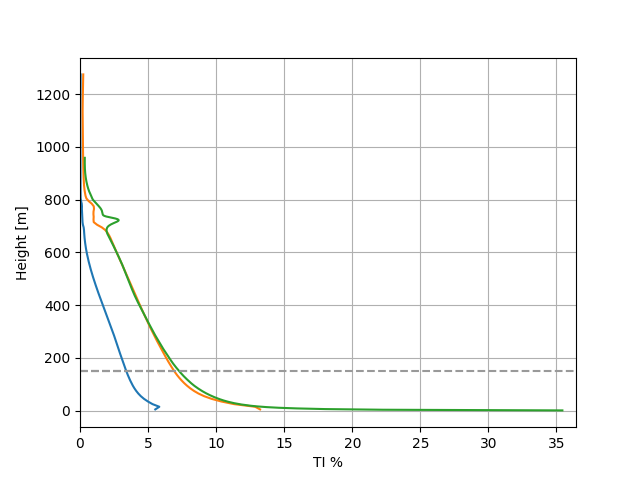

Nearest height to [5.] is [5.]
Nearest height to [5.] is [5.]
Nearest height to [5.] is [5.]
Nearest height to [5.] is [5.]
Nearest height to [5.] is [5.]
Nearest height to [5.] is [5.]
Nearest height to [15.] is [15.]
Nearest height to [15.] is [15.]
Nearest height to [15.] is [15.]
Nearest height to [15.] is [15.]
Nearest height to [15.] is [15.]
Nearest height to [15.] is [15.]
Nearest height to [25.] is [25.]
Nearest height to [25.] is [25.]
Nearest height to [25.] is [25.]
Nearest height to [25.] is [25.]
Nearest height to [25.] is [25.]
Nearest height to [25.] is [25.]
Nearest height to [35.] is [35.]
Nearest height to [35.] is [35.]
Nearest height to [35.] is [35.]
Nearest height to [35.] is [35.]
Nearest height to [35.] is [35.]
Nearest height to [35.] is [35.]
Nearest height to [45.] is [45.]
Nearest height to [45.] is [45.]
Nearest height to [45.] is [45.]
Nearest height to [45.] is [45.]
Nearest height to [45.] is [45.]
Nearest height to [45.] is [45.]
Nearest height to [55.

Nearest height to [395.] is [395.]
Nearest height to [395.] is [395.]
Nearest height to [405.] is [405.]
Nearest height to [405.] is [405.]
Nearest height to [405.] is [405.]
Nearest height to [405.] is [405.]
Nearest height to [405.] is [405.]
Nearest height to [405.] is [405.]
Nearest height to [415.] is [415.]
Nearest height to [415.] is [415.]
Nearest height to [415.] is [415.]
Nearest height to [415.] is [415.]
Nearest height to [415.] is [415.]
Nearest height to [415.] is [415.]
Nearest height to [425.] is [425.]
Nearest height to [425.] is [425.]
Nearest height to [425.] is [425.]
Nearest height to [425.] is [425.]
Nearest height to [425.] is [425.]
Nearest height to [425.] is [425.]
Nearest height to [435.] is [435.]
Nearest height to [435.] is [435.]
Nearest height to [435.] is [435.]
Nearest height to [435.] is [435.]
Nearest height to [435.] is [435.]
Nearest height to [435.] is [435.]
Nearest height to [445.] is [445.]
Nearest height to [445.] is [445.]
Nearest height to [4

Nearest height to [785.] is [785.]
Nearest height to [795.] is [795.]
Nearest height to [795.] is [795.]
Nearest height to [795.] is [795.]
Nearest height to [795.] is [795.]
Nearest height to [795.] is [795.]
Nearest height to [795.] is [795.]
Nearest height to [805.] is [805.]
Nearest height to [805.] is [805.]
Nearest height to [805.] is [805.]
Nearest height to [805.] is [805.]
Nearest height to [805.] is [805.]
Nearest height to [805.] is [805.]
Nearest height to [815.] is [815.]
Nearest height to [815.] is [815.]
Nearest height to [815.] is [815.]
Nearest height to [815.] is [815.]
Nearest height to [815.] is [815.]
Nearest height to [815.] is [815.]
Nearest height to [825.] is [825.]
Nearest height to [825.] is [825.]
Nearest height to [825.] is [825.]
Nearest height to [825.] is [825.]
Nearest height to [825.] is [825.]
Nearest height to [825.] is [825.]
Nearest height to [835.] is [835.]
Nearest height to [835.] is [835.]
Nearest height to [835.] is [835.]
Nearest height to [8

Nearest height to [1175.] is [1175.]
Nearest height to [1175.] is [1175.]
Nearest height to [1175.] is [1175.]
Nearest height to [1175.] is [1175.]
Nearest height to [1175.] is [1175.]
Nearest height to [1175.] is [1175.]
Nearest height to [1185.] is [1185.]
Nearest height to [1185.] is [1185.]
Nearest height to [1185.] is [1185.]
Nearest height to [1185.] is [1185.]
Nearest height to [1185.] is [1185.]
Nearest height to [1185.] is [1185.]
Nearest height to [1195.] is [1195.]
Nearest height to [1195.] is [1195.]
Nearest height to [1195.] is [1195.]
Nearest height to [1195.] is [1195.]
Nearest height to [1195.] is [1195.]
Nearest height to [1195.] is [1195.]
Nearest height to [1205.] is [1205.]
Nearest height to [1205.] is [1205.]
Nearest height to [1205.] is [1205.]
Nearest height to [1205.] is [1205.]
Nearest height to [1205.] is [1205.]
Nearest height to [1205.] is [1205.]
Nearest height to [1215.] is [1215.]
Nearest height to [1215.] is [1215.]
Nearest height to [1215.] is [1215.]
N

Nearest height to [285.] is [285.]
Nearest height to [285.] is [285.]
Nearest height to [285.] is [285.]
Nearest height to [285.] is [285.]
Nearest height to [295.] is [295.]
Nearest height to [295.] is [295.]
Nearest height to [295.] is [295.]
Nearest height to [295.] is [295.]
Nearest height to [295.] is [295.]
Nearest height to [295.] is [295.]
Nearest height to [305.] is [305.]
Nearest height to [305.] is [305.]
Nearest height to [305.] is [305.]
Nearest height to [305.] is [305.]
Nearest height to [305.] is [305.]
Nearest height to [305.] is [305.]
Nearest height to [315.] is [315.]
Nearest height to [315.] is [315.]
Nearest height to [315.] is [315.]
Nearest height to [315.] is [315.]
Nearest height to [315.] is [315.]
Nearest height to [315.] is [315.]
Nearest height to [325.] is [325.]
Nearest height to [325.] is [325.]
Nearest height to [325.] is [325.]
Nearest height to [325.] is [325.]
Nearest height to [325.] is [325.]
Nearest height to [325.] is [325.]
Nearest height to [3

Nearest height to [675.] is [675.]
Nearest height to [675.] is [675.]
Nearest height to [675.] is [675.]
Nearest height to [685.] is [685.]
Nearest height to [685.] is [685.]
Nearest height to [685.] is [685.]
Nearest height to [685.] is [685.]
Nearest height to [685.] is [685.]
Nearest height to [685.] is [685.]
Nearest height to [695.] is [695.]
Nearest height to [695.] is [695.]
Nearest height to [695.] is [695.]
Nearest height to [695.] is [695.]
Nearest height to [695.] is [695.]
Nearest height to [695.] is [695.]
Nearest height to [705.] is [705.]
Nearest height to [705.] is [705.]
Nearest height to [705.] is [705.]
Nearest height to [705.] is [705.]
Nearest height to [705.] is [705.]
Nearest height to [705.] is [705.]
Nearest height to [715.] is [715.]
Nearest height to [715.] is [715.]
Nearest height to [715.] is [715.]
Nearest height to [715.] is [715.]
Nearest height to [715.] is [715.]
Nearest height to [715.] is [715.]
Nearest height to [725.] is [725.]
Nearest height to [7

Nearest height to [1065.] is [1065.]
Nearest height to [1065.] is [1065.]
Nearest height to [1065.] is [1065.]
Nearest height to [1065.] is [1065.]
Nearest height to [1075.] is [1075.]
Nearest height to [1075.] is [1075.]
Nearest height to [1075.] is [1075.]
Nearest height to [1075.] is [1075.]
Nearest height to [1075.] is [1075.]
Nearest height to [1075.] is [1075.]
Nearest height to [1085.] is [1085.]
Nearest height to [1085.] is [1085.]
Nearest height to [1085.] is [1085.]
Nearest height to [1085.] is [1085.]
Nearest height to [1085.] is [1085.]
Nearest height to [1085.] is [1085.]
Nearest height to [1095.] is [1095.]
Nearest height to [1095.] is [1095.]
Nearest height to [1095.] is [1095.]
Nearest height to [1095.] is [1095.]
Nearest height to [1095.] is [1095.]
Nearest height to [1095.] is [1095.]
Nearest height to [1105.] is [1105.]
Nearest height to [1105.] is [1105.]
Nearest height to [1105.] is [1105.]
Nearest height to [1105.] is [1105.]
Nearest height to [1105.] is [1105.]
N

Nearest height to [66.25] is [66.25]
Nearest height to [66.25] is [66.25]
Nearest height to [66.25] is [66.25]
Nearest height to [66.25] is [66.25]
Nearest height to [66.25] is [66.25]
Nearest height to [68.75] is [68.75]
Nearest height to [68.75] is [68.75]
Nearest height to [68.75] is [68.75]
Nearest height to [68.75] is [68.75]
Nearest height to [68.75] is [68.75]
Nearest height to [68.75] is [68.75]
Nearest height to [71.25] is [71.25]
Nearest height to [71.25] is [71.25]
Nearest height to [71.25] is [71.25]
Nearest height to [71.25] is [71.25]
Nearest height to [71.25] is [71.25]
Nearest height to [71.25] is [71.25]
Nearest height to [73.75] is [73.75]
Nearest height to [73.75] is [73.75]
Nearest height to [73.75] is [73.75]
Nearest height to [73.75] is [73.75]
Nearest height to [73.75] is [73.75]
Nearest height to [73.75] is [73.75]
Nearest height to [76.25] is [76.25]
Nearest height to [76.25] is [76.25]
Nearest height to [76.25] is [76.25]
Nearest height to [76.25] is [76.25]
N

Nearest height to [163.75] is [163.75]
Nearest height to [163.75] is [163.75]
Nearest height to [163.75] is [163.75]
Nearest height to [166.25] is [166.25]
Nearest height to [166.25] is [166.25]
Nearest height to [166.25] is [166.25]
Nearest height to [166.25] is [166.25]
Nearest height to [166.25] is [166.25]
Nearest height to [166.25] is [166.25]
Nearest height to [168.75] is [168.75]
Nearest height to [168.75] is [168.75]
Nearest height to [168.75] is [168.75]
Nearest height to [168.75] is [168.75]
Nearest height to [168.75] is [168.75]
Nearest height to [168.75] is [168.75]
Nearest height to [171.25] is [171.25]
Nearest height to [171.25] is [171.25]
Nearest height to [171.25] is [171.25]
Nearest height to [171.25] is [171.25]
Nearest height to [171.25] is [171.25]
Nearest height to [171.25] is [171.25]
Nearest height to [173.75] is [173.75]
Nearest height to [173.75] is [173.75]
Nearest height to [173.75] is [173.75]
Nearest height to [173.75] is [173.75]
Nearest height to [173.75

Nearest height to [261.25] is [261.25]
Nearest height to [261.25] is [261.25]
Nearest height to [263.75] is [263.75]
Nearest height to [263.75] is [263.75]
Nearest height to [263.75] is [263.75]
Nearest height to [263.75] is [263.75]
Nearest height to [263.75] is [263.75]
Nearest height to [263.75] is [263.75]
Nearest height to [266.25] is [266.25]
Nearest height to [266.25] is [266.25]
Nearest height to [266.25] is [266.25]
Nearest height to [266.25] is [266.25]
Nearest height to [266.25] is [266.25]
Nearest height to [266.25] is [266.25]
Nearest height to [268.75] is [268.75]
Nearest height to [268.75] is [268.75]
Nearest height to [268.75] is [268.75]
Nearest height to [268.75] is [268.75]
Nearest height to [268.75] is [268.75]
Nearest height to [268.75] is [268.75]
Nearest height to [271.25] is [271.25]
Nearest height to [271.25] is [271.25]
Nearest height to [271.25] is [271.25]
Nearest height to [271.25] is [271.25]
Nearest height to [271.25] is [271.25]
Nearest height to [271.25

Nearest height to [361.25] is [361.25]
Nearest height to [361.25] is [361.25]
Nearest height to [361.25] is [361.25]
Nearest height to [361.25] is [361.25]
Nearest height to [361.25] is [361.25]
Nearest height to [363.75] is [363.75]
Nearest height to [363.75] is [363.75]
Nearest height to [363.75] is [363.75]
Nearest height to [363.75] is [363.75]
Nearest height to [363.75] is [363.75]
Nearest height to [363.75] is [363.75]
Nearest height to [366.25] is [366.25]
Nearest height to [366.25] is [366.25]
Nearest height to [366.25] is [366.25]
Nearest height to [366.25] is [366.25]
Nearest height to [366.25] is [366.25]
Nearest height to [366.25] is [366.25]
Nearest height to [368.75] is [368.75]
Nearest height to [368.75] is [368.75]
Nearest height to [368.75] is [368.75]
Nearest height to [368.75] is [368.75]
Nearest height to [368.75] is [368.75]
Nearest height to [368.75] is [368.75]
Nearest height to [371.25] is [371.25]
Nearest height to [371.25] is [371.25]
Nearest height to [371.25

Nearest height to [458.75] is [458.75]
Nearest height to [458.75] is [458.75]
Nearest height to [458.75] is [458.75]
Nearest height to [461.25] is [461.25]
Nearest height to [461.25] is [461.25]
Nearest height to [461.25] is [461.25]
Nearest height to [461.25] is [461.25]
Nearest height to [461.25] is [461.25]
Nearest height to [461.25] is [461.25]
Nearest height to [463.75] is [463.75]
Nearest height to [463.75] is [463.75]
Nearest height to [463.75] is [463.75]
Nearest height to [463.75] is [463.75]
Nearest height to [463.75] is [463.75]
Nearest height to [463.75] is [463.75]
Nearest height to [466.25] is [466.25]
Nearest height to [466.25] is [466.25]
Nearest height to [466.25] is [466.25]
Nearest height to [466.25] is [466.25]
Nearest height to [466.25] is [466.25]
Nearest height to [466.25] is [466.25]
Nearest height to [468.75] is [468.75]
Nearest height to [468.75] is [468.75]
Nearest height to [468.75] is [468.75]
Nearest height to [468.75] is [468.75]
Nearest height to [468.75

Nearest height to [556.25] is [556.25]
Nearest height to [558.75] is [558.75]
Nearest height to [558.75] is [558.75]
Nearest height to [558.75] is [558.75]
Nearest height to [558.75] is [558.75]
Nearest height to [558.75] is [558.75]
Nearest height to [558.75] is [558.75]
Nearest height to [561.25] is [561.25]
Nearest height to [561.25] is [561.25]
Nearest height to [561.25] is [561.25]
Nearest height to [561.25] is [561.25]
Nearest height to [561.25] is [561.25]
Nearest height to [561.25] is [561.25]
Nearest height to [563.75] is [563.75]
Nearest height to [563.75] is [563.75]
Nearest height to [563.75] is [563.75]
Nearest height to [563.75] is [563.75]
Nearest height to [563.75] is [563.75]
Nearest height to [563.75] is [563.75]
Nearest height to [566.25] is [566.25]
Nearest height to [566.25] is [566.25]
Nearest height to [566.25] is [566.25]
Nearest height to [566.25] is [566.25]
Nearest height to [566.25] is [566.25]
Nearest height to [566.25] is [566.25]
Nearest height to [568.75

Nearest height to [656.25] is [656.25]
Nearest height to [656.25] is [656.25]
Nearest height to [656.25] is [656.25]
Nearest height to [656.25] is [656.25]
Nearest height to [658.75] is [658.75]
Nearest height to [658.75] is [658.75]
Nearest height to [658.75] is [658.75]
Nearest height to [658.75] is [658.75]
Nearest height to [658.75] is [658.75]
Nearest height to [658.75] is [658.75]
Nearest height to [661.25] is [661.25]
Nearest height to [661.25] is [661.25]
Nearest height to [661.25] is [661.25]
Nearest height to [661.25] is [661.25]
Nearest height to [661.25] is [661.25]
Nearest height to [661.25] is [661.25]
Nearest height to [663.75] is [663.75]
Nearest height to [663.75] is [663.75]
Nearest height to [663.75] is [663.75]
Nearest height to [663.75] is [663.75]
Nearest height to [663.75] is [663.75]
Nearest height to [663.75] is [663.75]
Nearest height to [666.25] is [666.25]
Nearest height to [666.25] is [666.25]
Nearest height to [666.25] is [666.25]
Nearest height to [666.25

Nearest height to [753.75] is [753.75]
Nearest height to [756.25] is [756.25]
Nearest height to [756.25] is [756.25]
Nearest height to [756.25] is [756.25]
Nearest height to [756.25] is [756.25]
Nearest height to [756.25] is [756.25]
Nearest height to [756.25] is [756.25]
Nearest height to [758.75] is [758.75]
Nearest height to [758.75] is [758.75]
Nearest height to [758.75] is [758.75]
Nearest height to [758.75] is [758.75]
Nearest height to [758.75] is [758.75]
Nearest height to [758.75] is [758.75]
Nearest height to [761.25] is [761.25]
Nearest height to [761.25] is [761.25]
Nearest height to [761.25] is [761.25]
Nearest height to [761.25] is [761.25]
Nearest height to [761.25] is [761.25]
Nearest height to [761.25] is [761.25]
Nearest height to [763.75] is [763.75]
Nearest height to [763.75] is [763.75]
Nearest height to [763.75] is [763.75]
Nearest height to [763.75] is [763.75]
Nearest height to [763.75] is [763.75]
Nearest height to [763.75] is [763.75]
Nearest height to [766.25

Nearest height to [853.75] is [853.75]
Nearest height to [853.75] is [853.75]
Nearest height to [853.75] is [853.75]
Nearest height to [853.75] is [853.75]
Nearest height to [856.25] is [856.25]
Nearest height to [856.25] is [856.25]
Nearest height to [856.25] is [856.25]
Nearest height to [856.25] is [856.25]
Nearest height to [856.25] is [856.25]
Nearest height to [856.25] is [856.25]
Nearest height to [858.75] is [858.75]
Nearest height to [858.75] is [858.75]
Nearest height to [858.75] is [858.75]
Nearest height to [858.75] is [858.75]
Nearest height to [858.75] is [858.75]
Nearest height to [858.75] is [858.75]
Nearest height to [861.25] is [861.25]
Nearest height to [861.25] is [861.25]
Nearest height to [861.25] is [861.25]
Nearest height to [861.25] is [861.25]
Nearest height to [861.25] is [861.25]
Nearest height to [861.25] is [861.25]
Nearest height to [863.75] is [863.75]
Nearest height to [863.75] is [863.75]
Nearest height to [863.75] is [863.75]
Nearest height to [863.75

Nearest height to [951.25] is [951.25]
Nearest height to [951.25] is [951.25]
Nearest height to [951.25] is [951.25]
Nearest height to [953.75] is [953.75]
Nearest height to [953.75] is [953.75]
Nearest height to [953.75] is [953.75]
Nearest height to [953.75] is [953.75]
Nearest height to [953.75] is [953.75]
Nearest height to [953.75] is [953.75]
Nearest height to [956.25] is [956.25]
Nearest height to [956.25] is [956.25]
Nearest height to [956.25] is [956.25]
Nearest height to [956.25] is [956.25]
Nearest height to [956.25] is [956.25]
Nearest height to [956.25] is [956.25]
Nearest height to [958.75] is [958.75]
Nearest height to [958.75] is [958.75]
Nearest height to [958.75] is [958.75]
Nearest height to [958.75] is [958.75]
Nearest height to [958.75] is [958.75]
Nearest height to [958.75] is [958.75]


In [27]:
fig, ax = plt.subplots()
for n in range(Ncases):
    abl[n].plot_turbulence_intensity_profile(t_min=settling_time, height=height, ax=ax)